In [3]:
"""
Compute O/L offset for envisat from binned data
- area-weighted average of overlapping cells
- monthly climatology of all months

- uses the one file with all gridded data instead of individual files

Last modified: 30 Mar 2021
"""
#------------------------------------------------------------------
"""
# TEMPORAL VARIABILITY
- compute monthly spatial mean/median/stdev of the the bias
- make time series of the monthly spatial means + stdev
- is there a seasonal signal?

# SEASONAL VARIABILITY/CLIMATOLOGY
- average spatial mean by month
- look at StDev by month
- similar to Tiago's method

# SAPTIAL VARIABILITY
- divide into 30 -60 deg long regions
- look at time series of the monthly spatial averages for that region
- check how stdev compares with the climatology
"""
#------------------------------------------------------------------

## Import modules
import numpy as np
from numpy import ma

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

import xarray as xr
import pandas as pd

from scipy.stats import kurtosis, skew

import sys

#-------------------------------------------------------------------------------

def skew_kurt_hist(var, month):
	skew0 = kurtosis(var.flatten(), nan_policy='omit')
	kurt0 = skew(var.flatten(), nan_policy='omit')
	print('Kurtosis: ', skew0)
	print('Skewnesss: ', kurt0)

	fig, ax = plt.subplots()
	ax.hist(var.flatten()*1e2, bins=17,
	    label='n_thresh=%s'% str(n_thresh))
	ax.annotate('skew = %.4f' % skew0,
	    xy=(.15, .8),
	    xycoords='figure fraction')
	ax.annotate('kurt = %.4f' % kurt0,
	    xy=(.15, .75),
	    xycoords='figure fraction')

	ax.legend(loc=2)
	ax.set_title("%s O-L offset (cm) %s" % (satellite, month), loc='left')
	plt.tight_layout()

#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------

voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
import aux_func as ft
import aux_stereoplot as st
#- - - - - - - - - - - - - -

#-------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

total_area = ft.grid_area(eglon, eglat)
#-------------------------------------------------------

# # # # # # # # # # # #
statistic = 'mean'
satellite = 'cs2'
n_thresh = 30
# # # # # # # # # # # #

print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("> > satellite: %s" % satellite)
print("> > bin threshold: %s" % str(n_thresh))
print("- - - - - - - - - - - - - - \n")

#------------------------------------------------------------------
filename = 'b01_bin_ssha_OL_' + satellite + '_' + str(statistic) + '.nc'

with xr.open_dataset(bindir + filename) as bin0:
    print(bin0.keys)



- - - - - - - - - - - - - - 
> > bin statistic: mean
> > satellite: cs2
> > bin threshold: 30
- - - - - - - - - - - - - - 

<bound method Mapping.keys of <xarray.Dataset> Size: 126MB
Dimensions:    (time: 170, longitude: 360, latitude: 64)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    ssha_o     (time, longitude, latitude) float64 31MB ...
    ssha_l     (time, longitude, latitude) float64 31MB ...
    npts_o     (time, longitude, latitude) float64 31MB ...
    npts_l     (time, longitude, latitude) float64 31MB ...
    land_mask  (longitude, latitude) float64 184kB ...>


In [6]:

#------------------------------------------------------------------
# OFFSET computation
#------------------------------------------------------------------
# discard bins with fewer points than a certain threshold
bin0.ssha_o.values[bin0.npts_o<n_thresh] = np.nan
bin0.ssha_l.values[bin0.npts_l<n_thresh] = np.nan

# subtract leads from ocean
offset = (bin0.ssha_o - bin0.ssha_l).transpose('longitude', 'latitude', 'time')
offset.values[bin0.land_mask==1] = np.nan
offset = offset.to_dataset(name='ol_dif')

# create weights based on the surface area of each bin
ones = np.ones(offset.ol_dif.shape)
ones[np.isnan(offset.ol_dif.values)] = 0
arr_area = total_area[:,:, np.newaxis]*ones

# normalize weights
sum_area = arr_area.sum(axis=(0,1))
norm_area = arr_area/sum_area

#offset['weights'] = (('longitude', 'latitude', 'time'), norm_area) - Oana original code
offset['weights'] = (('longitude', 'latitude', 'time'), np.nan_to_num(norm_area))

#------------------------------------------------------------------
#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
# > > a. area weighted mean and StDev for every month
# results are the same as my implementation of the weighted avg
#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
weighted_obj = offset.ol_dif.weighted(offset.weights)
monthly_off_weighted = weighted_obj.mean(('longitude', 'latitude'))

# a. climatology of monthly area-weighted mean offset
monthly_off_clim = monthly_off_weighted.groupby('time.month').mean('time')

#- - - - - - - - - - - - - -

# standard deviation - weighted
monthly_res_sq = (offset.ol_dif - monthly_off_weighted)**2
weighted_obj_res_sq = monthly_res_sq.weighted(offset.weights)
monthly_variance_weighted = weighted_obj_res_sq.mean(('longitude', 'latitude'))
monthly_std_weighted = np.sqrt(monthly_variance_weighted)

# standard deviation - not weighted - ALMOST SIMILAR
monthly_variance = monthly_res_sq.mean(('longitude', 'latitude'))
monthly_std = np.sqrt(monthly_variance)

# spread of monthly area-weighted mean for every month
monthly_off_clim_std = monthly_off_weighted.groupby('time.month').std('time')

# error addition (sqrt of sum of square std)
comb_std_sum = (monthly_std**2).groupby('time.month').sum()
comb_std_clim = np.sqrt(comb_std_sum)

#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
# > > b. for every month, average offset in time in every bin
#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
offset_month = offset.ol_dif.groupby('time.month').mean('time')
offset_month_std = offset.ol_dif.groupby('time.month').std('time', ddof=1)

# keep only bins where std <= 0.7 m
offset_month.values[offset_month_std>0.7] = np.nan
offset_month.values[np.isnan(offset_month_std)] = np.nan

offset_month = offset_month.to_dataset(name='ol_m')

# > > b. area weighted avg for every time-averaged month
# create weights based on the surface area of each bin
ones = np.ones(offset_month.ol_m.shape)
ones[np.isnan(offset_month.ol_m.values)] = 0
arr_area = total_area[:,:, np.newaxis]*ones

offset_month['weights'] = (('longitude', 'latitude', 'month'), arr_area)

# climatology - weights for every calendar month avg (12)
off_obj = offset_month.ol_m.weighted(offset_month.weights)
off_mclim = off_obj.mean(('longitude', 'latitude'))

res = (offset_month.ol_m - off_mclim)**2
res_obj = res.weighted(offset_month.weights)
res_var = res_obj.mean(('longitude', 'latitude'))
off_mclim_std = np.sqrt(res_var)


/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_77382/4188529175.py:20: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area/sum_area


Kurtosis:  14.644094356954518
Skewnesss:  0.9833962940146427


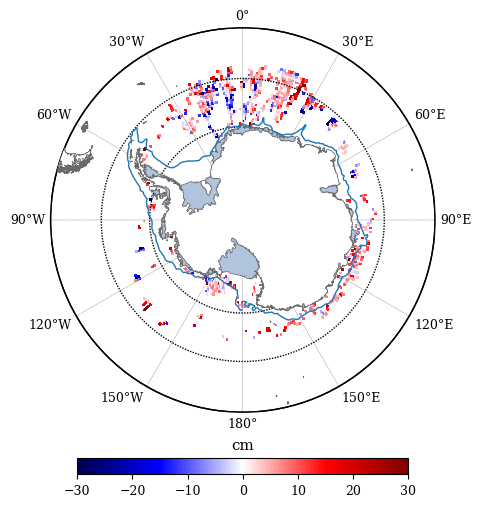

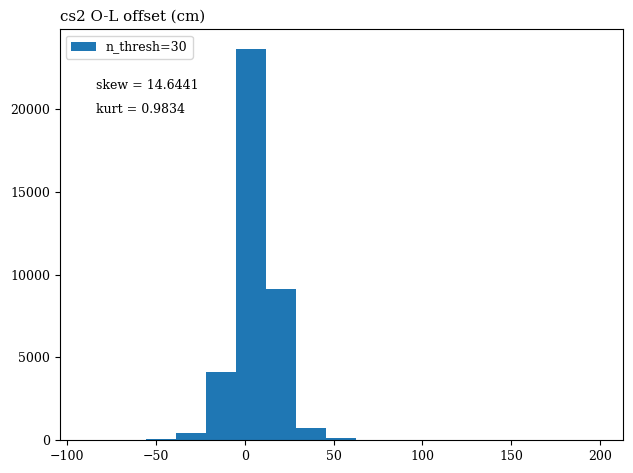

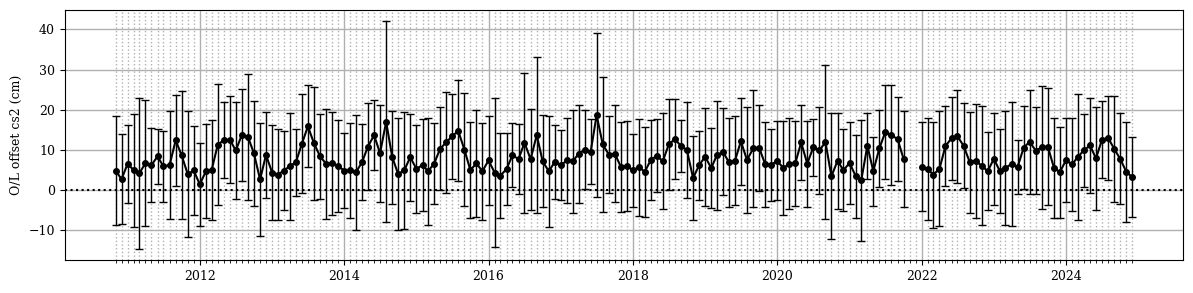

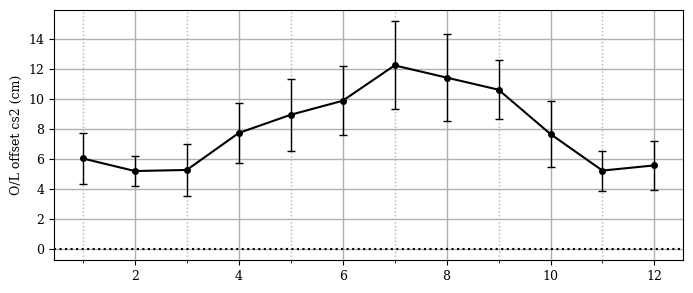

In [7]:

#------------------------------------------------------------------
# stereographical PLOT for individual months
#------------------------------------------------------------------
cbar_range = [-30, 30]
cbar_units = 'cm'
cmap = cm.seismic

k = 1
fig, ax, m = st.spstere_plot(eglon, eglat,
				offset.ol_dif.isel(time=k)*100,
				cbar_range, cmap, cbar_units, None)

#- - - - - - - - - - - - - -
var = offset.ol_dif.values.flatten()
skew_kurt_hist(var, '')

#- - - - - - - - - - - - - -
xtim = monthly_off_weighted.time.values
fig, ax = plt.subplots(figsize=(12,3))

ax.plot(xtim,
		monthly_off_weighted.values*1e2,
		c='k', marker='o', markersize=4)
ax.errorbar(xtim,
			monthly_off_weighted.values*1e2,
			yerr=monthly_std.values*1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset %s (cm)" % satellite)
ax.axhline(0, ls=':', c='k')
plt.tight_layout()

#- - - - - - - - - - - - - -
xtim = monthly_off_clim.month.values
fig, ax = plt.subplots(figsize=(7,3))

ax.plot(xtim,
		monthly_off_clim.values*1e2,
		c='k', marker='o', markersize=4)
ax.errorbar(xtim,
			monthly_off_clim.values*1e2,
			yerr=monthly_off_clim_std.values*1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset %s (cm)" % satellite)
ax.axhline(0, ls=':', c='k')
plt.tight_layout()

Kurtosis:  9.526230472327592
Skewnesss:  1.519032858864447
Kurtosis:  35.863827722125805
Skewnesss:  4.370056154072327


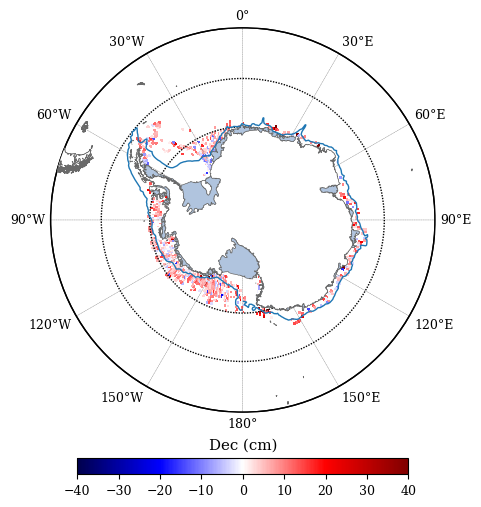

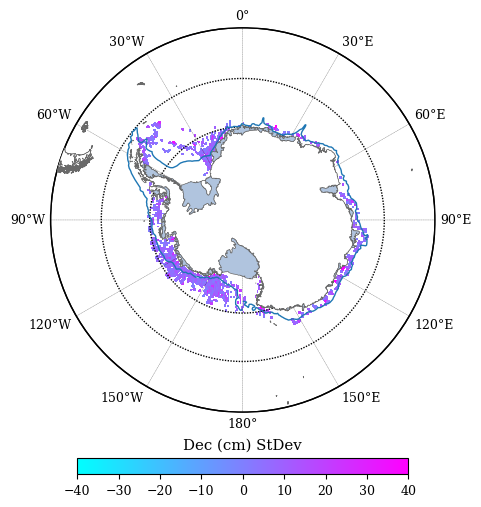

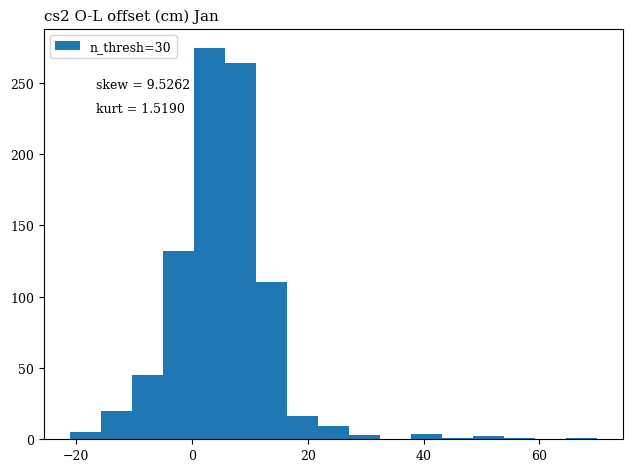

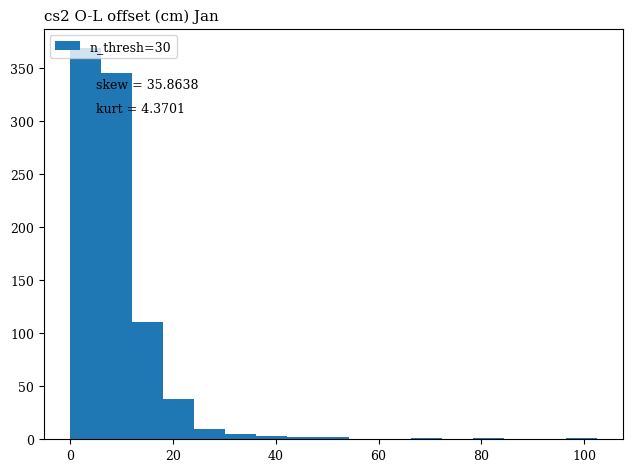

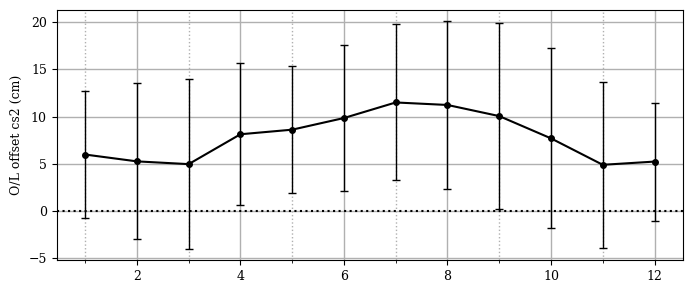

In [8]:

#------------------------------------------------------------------
# stereographical PLOT - maps of monthly avg offset & StDev
#------------------------------------------------------------------
cbar_range = [-40, 40]
cbar_units = 'Dec (cm)'
cmap = cm.seismic

k=1 	# 0-11 Jan-Dec
fig, ax, m = st.spstere_plot(eglon, eglat,
                offset_month.ol_m.isel(month=k)*100,
                cbar_range, cmap, cbar_units, None)
fig, ax, m = st.spstere_plot(eglon, eglat,
                offset_month_std.isel(month=k)*100,
                cbar_range, cm.cool, cbar_units + ' StDev', None)

#- - - - - - - - - - - - - -
var = offset_month.ol_m.isel(month=k).values
skew_kurt_hist(var, 'Jan')

var = offset_month_std.isel(month=k).values
skew_kurt_hist(var, 'Jan')

# monthly climatology
#- - - - - - - - - - - - - -
xtim = off_mclim.month.values
fig, ax = plt.subplots(figsize=(7,3))

ax.plot(xtim,
		off_mclim.values*1e2,
		c='k', marker='o', markersize=4)
ax.errorbar(xtim,
			off_mclim.values*1e2,
			yerr=off_mclim_std.values*1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset %s (cm)" % satellite)
ax.axhline(0, ls=':', c='k')
plt.tight_layout()


In [18]:
#B3
"""
Create files with gridded LRM/SAR/SARin data from CS2 (after 2010.11)
after correcting the along-track SLA leads.

- correct for O/L
- grid retrackers separately
- save arrays in a new file

OFFSET:
- discard data less than 10km away from land
- bin ocean/leads separately
     (compute mean/median of lat, lon, ssh, mss in every cell;
      interp to cell centre after the land mask)
- apply gridded land mask (for the points that might be inside contours)

- test difference between mean/median average in bins; how do I treat the monthly std?
- compute monthly climatology + error estimate for every point


Last modified: 10 Mar 2025
"""

## libraries go here
import numpy as np
from numpy import ma

from datetime import datetime
today = datetime.today()

import time as runtime
t_start = runtime.process_time()

from scipy.stats import binned_statistic_2d as bin2d

import xarray as xr
import pandas as pd

import os
import sys

# Define directories
#-------------------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'
lmdir = voldir + 'land_masks/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'



sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list
filenames = cs2_id_list

#-------------------------------------------------------------------------------
time = pd.date_range('2010-11-01', '2024-12-01', freq='1MS')

itt = len(time)
yr = time.year.values
months = time.month.values

#-------------------------------------------------------------------------------
# LAND MASK
#-------------------------------------------------------------------------------
# lon grid is -180/180, 0.5 lat x 1 lon
# lm shape=(mid_lon, mid_lat)
# land=1, ocean=0
#-------------------------------------------------------------------------------
lm = xr.open_dataset(lmdir+'land_mask_gridded_50s.nc')
lmask = lm.landmask.values

#------------------------------------------------------------------
# GRID
#------------------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

# bin centres
mid_lon = 0.5*(edges_lon[1:] + edges_lon[:-1])
mid_lat = 0.5*(edges_lat[1:] + edges_lat[:-1])
glat, glon = np.meshgrid(mid_lat, mid_lon)

londim, latdim = glat.shape

# # # # # # # # # # # #
statistic = 'median'
# # # # # # # # # # # #

print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("- - - - - - - - - - - - - - \n")
#------------------------------------------------------------------
# OL offset
#------------------------------------------------------------------
with xr.open_dataset(bindir + 'b02_OL_offset_cs2_30' + statistic +'.nc') as offset:
    print(offset.keys())

ol_offset = offset.ol_dif.values

ssha_sar_all, ssha_sarin_all = [np.zeros((itt, londim, latdim)) for _ in range(2)]
npts_sar_all, npts_sarin_all = [np.zeros((itt, londim, latdim)) for _ in range(2)]

for j, filename in enumerate(filenames):
    print(filename)

    filepath = ncdir + filename + '.nc'

    try:
        ds = xr.open_dataset(filepath)

        # Check that required variables are present and dataset is not empty
        required_vars = ['Latitude', 'Longitude', 'Elevation', 'SurfaceType', 'distance_m', 'MeanSSH', 'Time']
        if not all(var in ds.variables for var in required_vars) or ds.sizes == {}:
            print(f"MERGE {filename} is empty or missing required variables")
            continue

    except FileNotFoundError:
        print(f"MERGE {filename} not available")
        continue


    lat = ds.Latitude.values
    lon = ds.Longitude.values
    ssh = ds.Elevation.values
    surf = ds.SurfaceType.values
    dist = ds.distance_m.values
    mss = ds.MeanSSH.values
    retrack = ds.Retracker.values

    # time start-end date
    print("date start: %s" % ds.Time[0].dt.strftime('%m.%Y').values)
    print("date end: %s" % ds.Time[-1].dt.strftime('%m.%Y').values)

    if (ds.Time[0].dt.year.values != yr[j]
        or ds.Time[0].dt.month.values != months[j]):
        print("Year or month do not agree with time coordinate!")
        sys.exit()
    #------------------------------------------------------------------
    # 1 keep only data further than 10km from nearest coastline
    #------------------------------------------------------------------
    ssh = ssh[dist>1e4]
    lon = lon[dist>1e4]
    lat = lat[dist>1e4]
    mss = mss[dist>1e4]
    surf = surf[dist>1e4]
    retrack = retrack[dist>1e4]

    ssha = ssh-mss

    #------------------------------------------------------------------
    # 2 add OL offset to along-track lead SLA
    #------------------------------------------------------------------
    # add the monthly climatology correction to the along_track leads
    month = ds.Time.dt.month.values[j]

    ssha[surf==2] += ol_offset[month-1]

    #------------------------------------------------------------------
    # 3 split into retrackers; level SAR/SARIn to start with
    #------------------------------------------------------------------
    ssha_sar = ssha[retrack==2]
    lon_sar = lon[retrack==2]
    lat_sar = lat[retrack==2]

    ssha_sarin = ssha[retrack==3]
    lon_sarin = lon[retrack==3]
    lat_sarin = lat[retrack==3]

    #------------------------------------------------------------------
    # 4. BIN DATA
    #------------------------------------------------------------------
    print("binning SAR data ..")
    x, y, var = lon_sar, lat_sar, ssha_sar
    ssha_sar_bin = bin2d(x, y, var, statistic=statistic,
                 bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts_sar = np.histogram2d(x, y, bins=(edges_lon, edges_lat))[0]

    print("binning SARIn data ..")
    x, y, var = lon_sarin, lat_sarin, ssha_sarin
    ssha_sarin_bin = bin2d(x, y, var, statistic=statistic,
                 bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts_sarin = np.histogram2d(x, y, bins=(edges_lon, edges_lat))[0]

    #------------------------------------------------------------------
    # 5. gridded land mask
    #------------------------------------------------------------------
    ssha_sar_bin[lmask==1] = np.nan
    ssha_sarin_bin[lmask==1] = np.nan
    npts_sar[lmask==1] = 0
    npts_sarin[lmask==1] = 0

    ssha_sar_all[j, :, :] = ssha_sar_bin
    ssha_sarin_all[j, :, :] = ssha_sarin_bin
    npts_sar_all[j, :, :] = npts_sar
    npts_sarin_all[j, :, :] = npts_sarin

# save SLA in a pkl file
ds_all = xr.Dataset({'ssha_sar' : (('time', 'longitude', 'latitude'), ssha_sar_all),
                     'ssha_sarin' : (('time', 'longitude', 'latitude'), ssha_sarin_all),
                     'npts_sar' : (('time', 'longitude', 'latitude'), npts_sar_all),
                     'npts_sarin' : (('time', 'longitude', 'latitude'), npts_sarin_all),
                     'land_mask' : (('longitude', 'latitude'), lmask)},
                    coords={'longitude' : mid_lon,
                            'latitude' : mid_lat,
                            'time' : time})

newfilename = 'b03_bin_ssha_SAR_cs2_' + statistic+ '.nc'
ds_all.to_netcdf(bindir + newfilename)

t_stop = runtime.process_time()
print("execution time: %.1f min " %((t_stop-t_start)/60))

print('The end.')


- - - - - - - - - - - - - - 
> > bin statistic: median
- - - - - - - - - - - - - - 

KeysView(<xarray.Dataset> Size: 288B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ol_dif   (month) float64 96B ...
    ol_std   (month) float64 96B ...)
201011_MERGE
date start: 11.2010
date end: 11.2010
binning SAR data ..
binning SARIn data ..
201012_MERGE
date start: 12.2010
date end: 12.2010
binning SAR data ..
binning SARIn data ..
201101_MERGE
date start: 01.2011
date end: 01.2011
binning SAR data ..
binning SARIn data ..
201102_MERGE
date start: 02.2011
date end: 02.2011
binning SAR data ..
binning SARIn data ..
201103_MERGE
date start: 03.2011
date end: 03.2011
binning SAR data ..
binning SARIn data ..
201104_MERGE
date start: 04.2011
date end: 04.2011
binning SAR data ..
binning SARIn data ..
201105_MERGE
date start: 05.2011
date end: 05.2011
binning SAR data ..
binning SARIn data ..
201106_MERGE
date start: 06.2011
date en

In [11]:
print(filepath)


/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc/202111_MERGE.nc
